Setting up image colorization using modern PyTorch...
Using device: cpu
Model files downloaded successfully!

Ready for image colorization!
Please upload your black and white image:


Saving ChatGPT Image Jun 6, 2025, 10_12_05 PM.png to ChatGPT Image Jun 6, 2025, 10_12_05 PM.png

Processing: ChatGPT Image Jun 6, 2025, 10_12_05 PM.png


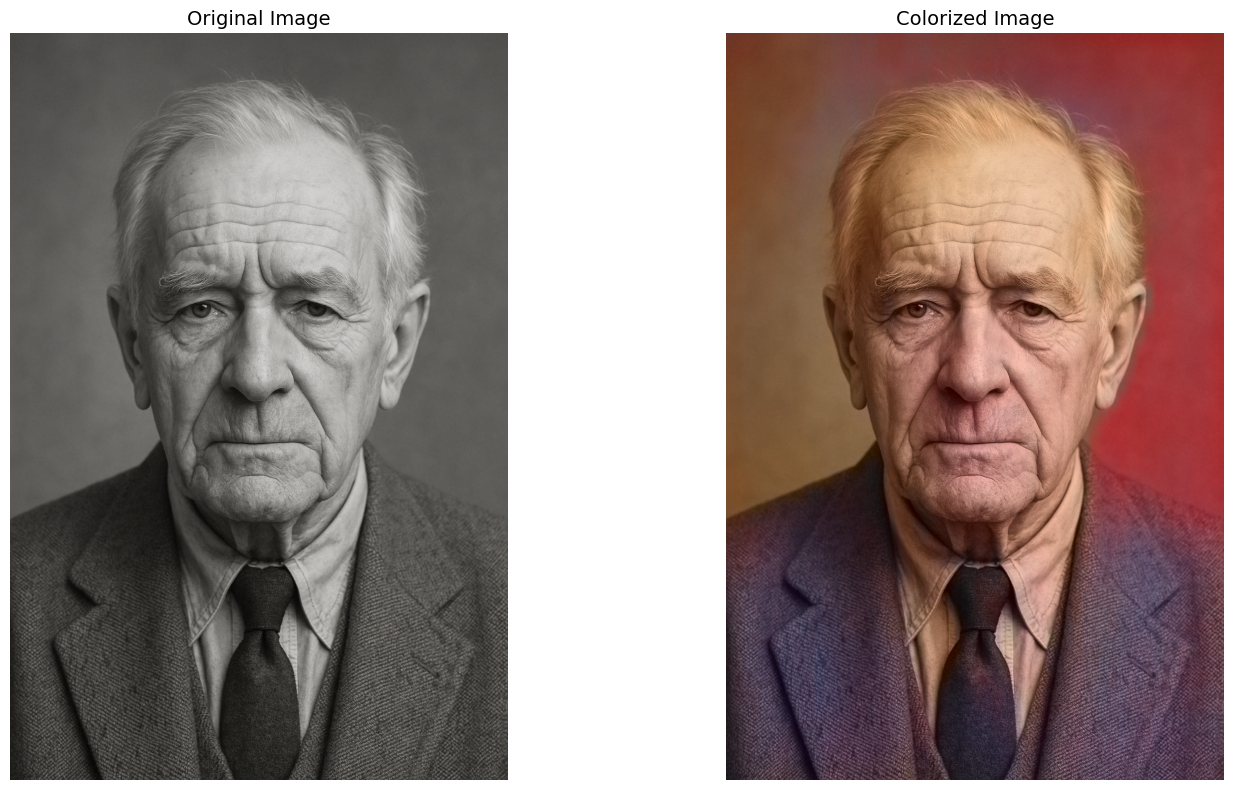

Colorized image saved as: colorized_ChatGPT Image Jun 6, 2025, 10_12_05 PM.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Enhanced colorization function available!
Use enhance_colorization(filename) for more vibrant results.

Additional functions available:
- batch_colorize(image_list): Process multiple images
- colorize_from_url(url): Colorize image from web URL
- enhance_colorization(image_path): Enhanced colorization with post-processing

IMAGE COLORIZATION SETUP COMPLETE!

How to use:
1. Run all cells above
2. Upload your black and white image when prompted
3. View the colorized result
4. Download the processed image

Tips for better results:
• Use high-quality, clear black and white images
• Images with good contrast work best
• Try the enhance_colorization() function for more vibrant colors
• Portraits and landscapes typically work very well

Troubleshooting:
• If download fails, files are still saved in the Colab environment
• Check file format - JPG, PNG, and BMP are supported
• Large images may take longer to process


'\n# Test with a sample image from the web\nsample_url = "https://upload.wikimedia.org/wikipedia/commons/5/50/Albert_Einstein_%28Nobel%29.png"\nprint("\\nTesting with sample image...")\ncolorize_from_url(sample_url)\n'

In [2]:
# Image Colorization using DeOldify in Google Colab
# This code colorizes black and white images using deep learning

# Step 1: Install required packages with compatible versions
!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib pillow numpy
!pip install scikit-image

# Alternative approach using a simpler, more reliable method
print("Setting up image colorization using modern PyTorch...")

# Step 2: Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from google.colab import files
import requests
from io import BytesIO

# Step 3: Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download pre-trained colorization model (Zhang et al.)
def download_colorization_model():
    """Download the pre-trained colorization model files"""
    print("Downloading colorization model files...")

    # URLs for the model files
    prototxt_url = "https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/models/colorization_deploy_v2.prototxt"
    model_url = "https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1"
    pts_url = "https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/resources/pts_in_hull.npy"

    # Download files
    try:
        # Download prototxt
        response = requests.get(prototxt_url)
        with open('colorization_deploy_v2.prototxt', 'wb') as f:
            f.write(response.content)

        # Download model
        response = requests.get(model_url)
        with open('colorization_release_v2.caffemodel', 'wb') as f:
            f.write(response.content)

        # Download pts
        response = requests.get(pts_url)
        with open('pts_in_hull.npy', 'wb') as f:
            f.write(response.content)

        print("Model files downloaded successfully!")
        return True
    except Exception as e:
        print(f"Error downloading model files: {e}")
        return False

# Download the model
model_ready = download_colorization_model()

# Step 4: Enhanced colorization function using OpenCV DNN
def colorize_image(image_path):
    """
    Colorize a black and white image using pre-trained neural network

    Args:
        image_path: Path to the input black and white image

    Returns:
        Colorized image as numpy array
    """
    if not model_ready:
        print("Model files not available. Please check the download.")
        return None

    try:
        # Load the colorization network
        net = cv2.dnn.readNetFromCaffe('colorization_deploy_v2.prototxt',
                                       'colorization_release_v2.caffemodel')

        # Load cluster centers
        pts = np.load('pts_in_hull.npy')

        # Add the cluster centers as 1x1 convolutions to the model
        class8 = net.getLayerId("class8_ab")
        conv8 = net.getLayerId("conv8_313_rh")
        pts = pts.transpose().reshape(2, 313, 1, 1)
        net.getLayer(class8).blobs = [pts.astype("float32")]
        net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

        # Load and preprocess the input image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            return None

        scaled = image.astype("float32") / 255.0
        lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

        resized = cv2.resize(lab, (224, 224))
        L = cv2.split(resized)[0]
        L -= 50  # Mean centering

        # Run the L channel through the network
        net.setInput(cv2.dnn.blobFromImage(L))
        ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

        # Resize the predicted 'ab' volume to the same dimensions as our image
        ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

        # Combine L channel with predicted ab channels
        L = cv2.split(lab)[0]
        colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

        # Convert back to RGB
        colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
        colorized = np.clip(colorized, 0, 1)
        colorized = (255 * colorized).astype("uint8")

        return colorized

    except Exception as e:
        print(f"Error during colorization: {e}")
        return None

# Step 5: Upload and process your image
print("\nReady for image colorization!")
print("Please upload your black and white image:")
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")

    # Save uploaded file
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])

    # Colorize the image
    colorized_img = colorize_image(filename)

    if colorized_img is not None:
        # Load original for comparison
        original = cv2.imread(filename)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        colorized_rgb = cv2.cvtColor(colorized_img, cv2.COLOR_BGR2RGB)

        # Display results
        plt.figure(figsize=(16, 8))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_rgb)
        plt.title('Original Image', fontsize=14)
        plt.axis('off')

        # Colorized image
        plt.subplot(1, 2, 2)
        plt.imshow(colorized_rgb)
        plt.title('Colorized Image', fontsize=14)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Save colorized image
        output_filename = f"colorized_{filename}"
        cv2.imwrite(output_filename, colorized_img)
        print(f"Colorized image saved as: {output_filename}")

        # Download the result
        files.download(output_filename)
    else:
        print(f"Failed to colorize {filename}")

# Additional enhancement function
def enhance_colorization(image_path, saturation_boost=1.3, contrast_boost=1.1):
    """
    Apply post-processing to enhance colorization results
    """
    colorized = colorize_image(image_path)
    if colorized is None:
        return None

    # Convert to HSV for saturation adjustment
    hsv = cv2.cvtColor(colorized, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] = hsv[:, :, 1] * saturation_boost  # Increase saturation
    hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)

    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Adjust contrast
    enhanced = cv2.convertScaleAbs(enhanced, alpha=contrast_boost, beta=0)

    return enhanced

print("\nEnhanced colorization function available!")
print("Use enhance_colorization(filename) for more vibrant results.")

# Batch processing function
def batch_colorize(image_paths, output_dir="colorized_results"):
    """
    Colorize multiple images at once
    """
    os.makedirs(output_dir, exist_ok=True)
    results = []

    for img_path in image_paths:
        print(f"Processing {img_path}...")
        colorized = colorize_image(img_path)

        if colorized is not None:
            output_path = os.path.join(output_dir, f"colorized_{os.path.basename(img_path)}")
            cv2.imwrite(output_path, colorized)
            results.append(output_path)
            print(f"Saved: {output_path}")
        else:
            print(f"Failed to colorize {img_path}")

    return results

# Function to colorize from URL
def colorize_from_url(image_url):
    """
    Download and colorize an image from URL
    """
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        # Save temporarily
        temp_path = "temp_image.jpg"
        img.save(temp_path)

        # Colorize
        colorized = colorize_image(temp_path)

        if colorized is not None:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title('Original')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB))
            plt.title('Colorized')
            plt.axis('off')
            plt.show()

            # Save result
            cv2.imwrite("url_colorized.jpg", colorized)
            files.download("url_colorized.jpg")

        # Clean up
        os.remove(temp_path)

    except Exception as e:
        print(f"Error processing URL image: {e}")

print("\nAdditional functions available:")
print("- batch_colorize(image_list): Process multiple images")
print("- colorize_from_url(url): Colorize image from web URL")
print("- enhance_colorization(image_path): Enhanced colorization with post-processing")

print("\n" + "="*60)
print("IMAGE COLORIZATION SETUP COMPLETE!")
print("="*60)
print("\nHow to use:")
print("1. Run all cells above")
print("2. Upload your black and white image when prompted")
print("3. View the colorized result")
print("4. Download the processed image")
print("\nTips for better results:")
print("• Use high-quality, clear black and white images")
print("• Images with good contrast work best")
print("• Try the enhance_colorization() function for more vibrant colors")
print("• Portraits and landscapes typically work very well")
print("\nTroubleshooting:")
print("• If download fails, files are still saved in the Colab environment")
print("• Check file format - JPG, PNG, and BMP are supported")
print("• Large images may take longer to process")

# Example usage with sample image (uncomment to test)
"""
# Test with a sample image from the web
sample_url = "https://upload.wikimedia.org/wikipedia/commons/5/50/Albert_Einstein_%28Nobel%29.png"
print("\\nTesting with sample image...")
colorize_from_url(sample_url)
"""